In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import eig
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util   # KR-SBERT : !pip install -U sentence-transformers
from sklearn.cluster import KMeans
import networkx as nx
from networkx.linalg.spectrum import normalized_laplacian_spectrum
import community as cm
from pyvis.network import Network
from node2vec import Node2Vec
from kneed import KneeLocator
import json
import network_function as func

### 데이터 가져오기 및 전처리

In [2]:
##################### 단어 의미 유사도 행렬 관련 데이터


# GPT로 처리한 테마-연관어 데이터셋 import
themes = pd.read_excel("./data/news_theme_data_230617-230623_combined.xlsx")  # 6월 3주차 테마-연관어 데이터
    # 6월 1주차 테마-연관어 데이터 : "./data/news_theme_data_230603-230609_combined.xlsx"
    # 6월 2주차 테마-연관어 데이터 : "./data/news_theme_data_230610-230616_combined.xlsx"
theme_key = themes.copy()

# 그 중 테마명 및 연관어 1~5만을 가져오기
theme_key = theme_key[["테마명","연관어1","연관어2","연관어3","연관어4","연관어5"]]

# 데이터 전처리 : '없음' 테마명 제거, NaN 포함된 열 모두 제거
theme_key = theme_key[theme_key['테마명'] != '없음']  # '없음' 테마명 제거
theme_key = theme_key.dropna().reset_index(drop=True)  # NaN 포함된 열 모두 제거

# 테마-연관어 딕셔너리 생성 : 3회 이상 등장한 연관어에 대해 테마-연관어 딕셔너리를 생성
keyword_unique = pd.melt(theme_key, id_vars=['테마명'], value_vars=['연관어1', '연관어2', '연관어3', '연관어4', '연관어5'])
keyword_unique = keyword_unique.drop(axis = 1, columns = 'variable')
k = keyword_unique.groupby(['테마명'])['value'].value_counts()
k = k[k>2].to_frame().reset_index()                                     # 3회 이상 등장한 연관어 목록 추출
related_keywords = k.groupby('테마명').value.apply(list).to_dict()      # 테마-연관어를 딕셔너리 형태로 저장

# 문장 만들기
sentence_theme = func.convert_dict_to_list(related_keywords)

In [3]:
##################### 테마지수 유사도 행렬 관련 데이터

# 계산된 테마지수 데이터셋 import
theme_index_date = pd.read_csv("./data/theme_index_week3.csv").set_index('일자')  # 6월 3주차 테마지수 데이터
    # 6월 1주차 테마지수 데이터 : "./data/theme_index_week1.csv"
    # 6월 2주차 테마지수 데이터 : "./data/theme_index_week2.csv"

### 단어 의미 유사도 행렬 생성
앞서 생성된 테마-연관어 문장을 이용하여 테마 간의 의미 유사도를 계산합니다. 유사도 계산 시, KR-SBERT 모형을 활용하여 코사인 유사도를 계산합니다.

In [4]:
# 유사도 계산을 위해 KR-SBERT를 이용하여 각 문장을 임베딩
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
similarity_vectors = model.encode(sentence_theme, show_progress_bar=True)

# 문장 간의 코사인 유사도 계산
similarity = util.cos_sim(similarity_vectors, similarity_vectors)

# 단어 의미 유사도 행렬 생성. 해당 문장의 테마명을 행이름 및 열이름으로 지정
similarity = pd.DataFrame(similarity.numpy(), index=related_keywords.keys(), columns=related_keywords.keys())

# 대각원소 0으로 치환
## 동일한 문장 간의 유사도는 1이므로, 현재 유사도 행렬의 대각원소 값은 모두 1입니다.
## 동일한 문장의 유사도는 본 분석의 관심 대상이 아닐 뿐 아니라, 대각원소가 0보다 큰 값을 가지게 되면 이후 네트워크 분석 과정에서 self-loop 등의 문제가 발생하므로 0으로 치환하여 제거합니다.
np.fill_diagonal(similarity.values, 0)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
similarity

,2차전지,5G,ADC분야,AI,AI 챗봇,ELW,HLB컨소시엄,HSD엔진,ISDS,LG화학,...,핀테크,하락장,합병,항공기,항공우주,해외직접투자,해운,화학,환율하락,희토류
2차전지,0.000000,0.184972,0.498883,0.093762,0.047894,0.148444,0.356486,0.088991,-0.017398,0.621446,...,0.073825,-0.013610,-0.004034,0.019909,0.136452,-0.040597,0.051028,0.347757,-0.064641,0.284590
5G,0.184972,0.000000,0.062620,0.200463,0.270312,0.077877,0.146526,0.083485,0.075333,0.293792,...,0.192321,-0.013957,0.051098,0.145088,0.198754,-0.024206,-0.038279,0.152997,0.022544,-0.010751
ADC분야,0.498883,0.062620,0.000000,0.325579,0.053965,0.392295,0.535668,0.347458,0.166067,0.497630,...,0.223779,0.109752,0.231717,0.133266,0.229248,0.157224,0.315909,0.206865,0.070859,0.287518
AI,0.093762,0.200463,0.325579,0.000000,0.541532,0.310777,0.433844,0.262719,0.447957,0.229502,...,0.568709,0.114601,0.369713,0.257364,0.212621,0.273344,0.202020,0.175885,0.359206,0.126636
AI 챗봇,0.047894,0.270312,0.053965,0.541532,0.000000,0.033364,0.134142,0.081882,0.127165,0.108340,...,0.338976,-0.019706,0.072368,0.094137,0.080654,0.125547,0.039370,-0.000553,0.111428,-0.036742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
해외직접투자,-0.040597,-0.024206,0.157224,0.273344,0.125547,0.272279,0.155866,0.149850,0.222972,0.064606,...,0.206611,0.169907,0.126936,0.274589,0.070832,0.000000,0.321676,0.226365,0.240441,0.271953
해운,0.051028,-0.038279,0.315909,0.202020,0.039370,0.323014,0.144542,0.295491,0.144597,0.122666,...,0.173339,0.047346,0.189427,0.379672,0.290500,0.321676,0.000000,0.195013,0.193814,0.272579
화학,0.347757,0.152997,0.206865,0.175885,-0.000553,0.134032,0.194661,0.214697,0.203866,0.447645,...,0.017734,0.276402,0.014843,0.291926,0.270231,0.226365,0.195013,0.000000,0.271511,0.314609
환율하락,-0.064641,0.022544,0.070859,0.359206,0.111428,0.107135,0.162148,0.213480,0.321145,-0.019818,...,0.238873,0.230020,0.209182,0.266112,0.202098,0.240441,0.193814,0.271511,0.000000,0.142040


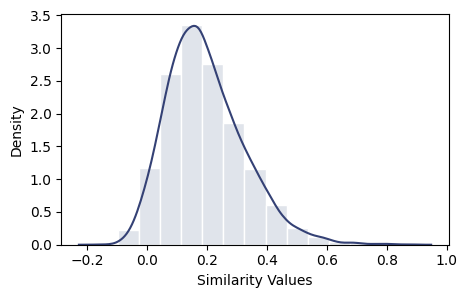

In [6]:
# 단어 의미 유사도 행렬의 유사도 분포 시각화
func.plot_similarity_distribution(similarity, name="./plot/theme_similarity_distribution.png")

### 테마지수 유사도 행렬 생성
계산된 테마지수를 이용하여 테마지수 움직임의 유사도를 계산합니다. 각 테마별 테마지수 시계열 벡터를 표준화 한 뒤, 이 벡터 간의 유클리드 거리를 계산합니다.

In [7]:
# 앞서 계산된 테마지수를 이용하여 테마지수 유사도 행렬 생성
theme_index_matrix = func.calculate_similarity(theme_index_date).astype(float)

In [8]:
theme_index_matrix

,2차전지,5G,ADC분야,AI,AI 챗봇,ELW,HLB컨소시엄,HSD엔진,ISDS,LG화학,...,텍,파운드리,핀테크,합병,항공기,항공우주,해외직접투자,해운,화학,희토류
2차전지,0.000000,0.127860,0.133908,0.142710,0.158679,0.138499,0.137024,0.209227,0.150155,0.159704,...,0.145568,0.233762,0.147260,0.133393,0.230977,0.158222,0.129954,0.174499,0.171039,0.190406
5G,0.127860,0.000000,0.392754,0.170475,0.141167,0.369606,0.378314,0.134731,0.232153,0.255011,...,0.263768,0.131911,0.308192,0.336451,0.126700,0.179866,0.217388,0.127572,0.190549,0.169526
ADC분야,0.133908,0.392754,0.000000,0.160227,0.135050,0.440643,0.518153,0.137061,0.314680,0.316852,...,0.339169,0.133939,0.375707,0.444798,0.130256,0.191661,0.212651,0.127407,0.213635,0.196396
AI,0.142710,0.170475,0.160227,0.000000,0.325715,0.160998,0.161317,0.128735,0.152403,0.152742,...,0.153959,0.137116,0.149931,0.166772,0.141088,0.166757,0.240534,0.180009,0.138709,0.135008
AI 챗봇,0.158679,0.141167,0.135050,0.325715,0.000000,0.136231,0.134892,0.136118,0.133931,0.133367,...,0.135647,0.148594,0.130850,0.139509,0.154692,0.152135,0.182654,0.215262,0.130226,0.126616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
항공우주,0.158222,0.179866,0.191661,0.166757,0.152135,0.172840,0.196355,0.164393,0.204553,0.192196,...,0.168810,0.160527,0.179025,0.187945,0.164059,0.000000,0.170888,0.172588,0.180402,0.184886
해외직접투자,0.129954,0.217388,0.212651,0.240534,0.182654,0.205319,0.213511,0.124241,0.184545,0.179627,...,0.185757,0.123315,0.177218,0.224561,0.131215,0.170888,0.000000,0.153240,0.145456,0.153868
해운,0.174499,0.127572,0.127407,0.180009,0.215262,0.124496,0.126358,0.175613,0.138743,0.126617,...,0.126869,0.178971,0.125393,0.132961,0.216806,0.172588,0.153240,0.000000,0.141136,0.145035
화학,0.171039,0.190549,0.213635,0.138709,0.130226,0.217175,0.206895,0.173939,0.269786,0.249091,...,0.231494,0.167355,0.268397,0.218549,0.159155,0.180402,0.145456,0.141136,0.000000,0.249327


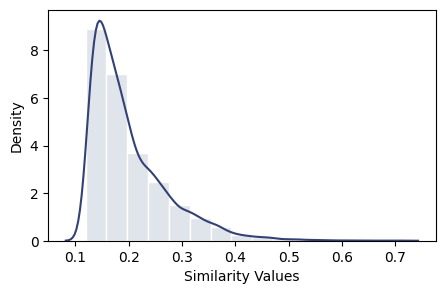

In [9]:
# 테마지수 유사도 행렬의 유사도 분포 시각화
func.plot_similarity_distribution(theme_index_matrix, name="./plot/W3_1-2.theme_index_similarity_distribution.png")

### 테마 네트워크 행렬 생성

우선, **단어 의미 유사도 행렬과 테마지수 유사도 행렬의 크기를 통일**합니다. 테마 지수 계산 과정에서 몇몇 테마의 관련 종목이 존재하지 않아 탈락하는 테마가 생길 수 있으므로, 테마 지수 유사도 행렬의 크기는 단어 의미 유사도 행렬의 크기보다 항상 작거나 같습니다. 관련 종목이 없다는 의미는, 사실상 주식 시장에서 해당 테마가 무의미한 것이라고 생각할 수 있으므로, 해당 테마를 단어 의미 유사도 행렬에서도 제거함으로써 두 행렬의 크기를 통일합니다.

이후, 단어 의미 유사도 행렬과 테마지수 유사도 행렬의 **가중합으로서 테마 네트워크 행렬을 생성**합니다. 두 행렬의 비중을 0:10부터 10:0까지 조정하면서, 각 비중별로 특정 테마에 대한 유사한 테마들이 잘 추출되는지를 확인합니다.

In [10]:
##################### 두 유사도 행렬의 전처리


# 테마지수 유사도 행렬 기반, 단어 의미 유사도 행렬 규모 축소(일부 테마 탈락)
theme_id = theme_index_matrix.index
similarity_filtered = similarity.loc[theme_id, theme_id]
# print([item for item in similarity.index if item not in theme_id])     # 이 코드를 통해 탈락한 테마명을 확인할 수 있습니다.

# 단어 의미 유사도 행렬에서 음수 값을 0으로 대체
    ## 단어 의미 유사도 행렬에서 코사인 유사도를 이용하므로, 음수 값이 나타날 수 있습니다. 두 테마가 반대 방향에 위치한다는 것을 나타내는 음수 값은 우리의 관심 대상이 아니므로, 음수 값을 모두 0으로 변환합니다.
similarity_filtered[similarity_filtered < 0] = 0  

# 두 유사도 행렬 모두 0~1 범위로 표준화
    ## 두 유사도 행렬에서 각각의 유사도 분포에 차이가 존재합니다. 단어 의미 유사도에 비해 테마지수 유사도가 전반적으로 작은 값을 갖고 있습니다.
    ## 데이터의 특성을 최대한 보존하면서 두 유사도 행렬의 분포를 유사하게 통일하기 위해, min-max scaling을 통해 유사도를 0~1 범위로 수정합니다.
similarity_filtered_rescaled = func.min_max_scaling_matrix(similarity_filtered)   # 원래는 (0.0, 0.865)
theme_index_matrix_rescaled = func.min_max_scaling_matrix(theme_index_matrix)     # 원래는 (0.119, 0.706)

In [11]:
##################### 두 유사도 행렬의 최적 가중치 찾기


weights = [(i/10, 1 - i/10) for i in range(11)]  # 두 유사도 행렬에 대한 가중치 생성 (0:10 ~ 10:0)
ratio_adjacencies = {}  # 각 가중치에 대한 테마 네트워크 인접행렬 저장할 딕셔너리
ratio_thresholds = {}   # 각 가중치에 대한 테마 네트워크의 edge 필터링 기준값 저장할 딕셔너리
ratio_filtered = {}     # 각 가중치에 대해 edge가 필터링된 인접행렬 저장할 딕셔너리
target_degree = 3       # edge 필터링 시, 네트워크의 평균 연결도가 3이 되는 threshold를 찾도록 지정

# 각 weight에 대한 연산 수행
for idx, (w1, w2) in enumerate(weights):
    ratio_adjacencies[idx] = (w1 * similarity_filtered + w2 * theme_index_matrix).astype(float)     # 가중치별 테마 네트워크 인접행렬
    ratio_thresholds[idx] = func.find_threshold_for_avg_degree(ratio_adjacencies[idx], target_degree=target_degree)  # 가중치별 edge 필터링 기준값
    ratio_filtered[idx] = func.filter_smiliarity(ratio_adjacencies[idx], filtering=ratio_thresholds[idx])    # 가중치별 필터링된 인접행렬

# 가중치의 11개 가능한 조합에 대해 계산된 각각의 테마 네트워크 인접행렬을 `ratio_test` 리스트에 저장
ratio_test = [ratio_filtered[i] for i in range(11)]

# `ratio_test`에 저장된 각 유사도 행렬에서 각 테마별 연관 테마 목록을 생성하고, 결과를 `test_results` 리스트에 저장
test_results = [func.process_similarities(similarity) for similarity in ratio_test]

# 각 가중치에 대해, 특정 테마별로 상위 연관 테마를 확인하는 데이터프레임 생성 (예시 : '블록체인' 테마)
func.get_combined_theme_related_terms(test_results, '블록체인').iloc[:,0:10]

,연관테마1,연관테마2,연관테마3,연관테마4,연관테마5,연관테마6,연관테마7,연관테마8,연관테마9,연관테마10
단어의미 : 테마지수,,,,,,,,,,
0:10,ADC분야,유전자 치료제/분석,거래량,영화관,HLB컨소시엄,게임,국민연금,세포유전자치료제,합병,SK이노베이션
1:9,ADC분야,유전자 치료제/분석,거래량,게임,영화관,HLB컨소시엄,국민연금,합병,세포유전자치료제,SK이노베이션
2:8,ADC분야,게임,유전자 치료제/분석,HLB컨소시엄,거래량,영화관,국민연금,합병,비트코인,세포유전자치료제
3:7,게임,ADC분야,HLB컨소시엄,비트코인,유전자 치료제/분석,영화관,합병,거래량,국민연금,벤처
4:6,게임,비트코인,ADC분야,HLB컨소시엄,핀테크,벤처,암호화폐,영화관,유전자 치료제/분석,합병
5:5,게임,비트코인,핀테크,암호화폐,HLB컨소시엄,ADC분야,벤처,시큐리티,합병,영화관
6:4,게임,비트코인,암호화폐,핀테크,벤처,HLB컨소시엄,시큐리티,AI,ADC분야,중국
7:3,비트코인,암호화폐,게임,핀테크,AI,시큐리티,벤처,HLB컨소시엄,스마트물류솔루션,중국
8:2,암호화폐,비트코인,게임,핀테크,AI,시큐리티,벤처,,,


In [12]:
# 다양한 테마에 대해 가중치별 상위 연관 테마를 확인했을 때, 단어 의미 유사도 행렬과 테마지수 유사도 행렬의 가중합 비율을 7:3으로 설정하는 것이 최적이라는 결론을 내렸습니다.

# 두 유사도 행렬에 대한 7:3 비율의 가중합으로 테마 네트워크 인접행렬 생성
theme_adjacency = (0.7 * similarity_filtered + 0.3 * theme_index_matrix).astype(float)

# 필터링 기준값 찾기
theme_thresholds = func.find_threshold_for_avg_degree(theme_adjacency, target_degree=target_degree)
print("filtering threshold is : ", round(theme_thresholds,2))

# 찾은 기준값 바탕으로 edge에 대한 필터링 수행.
# 이를 통해 최종적인 테마 네트워크 행렬이 도출되었습니다.
theme_filtered = func.filter_smiliarity(theme_adjacency, filtering=theme_thresholds)

filtering threshold is :  0.41


In [13]:
theme_filtered

,2차전지,ADC분야,AI,AI 챗봇,ELW,HLB컨소시엄,HSD엔진,ISDS,LG화학,LNG,...,컴투스,코스피,타이어,텍,파운드리,핀테크,합병,항공우주,화학,희토류
2차전지,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.482924,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ADC분야,0.0,0.0,0.000000,0.000000,0.0,0.530413,0.0,0.000000,0.443397,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
AI,0.0,0.0,0.000000,0.476787,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.443075,0.0,0.0,0.0,0.0
AI 챗봇,0.0,0.0,0.476787,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ELW,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
핀테크,0.0,0.0,0.443075,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
합병,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.482323,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
항공우주,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
화학,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


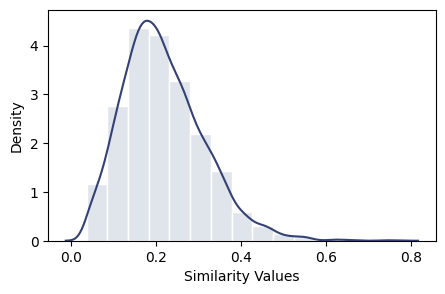

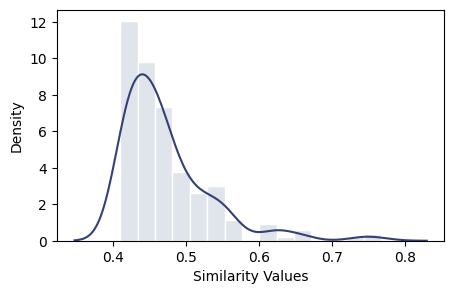

In [14]:
# 유사도 분포 시각화


# 최종 테마 유사도 행렬의 유사도 분포
func.plot_similarity_distribution(theme_adjacency, "./plot/W3_2-1.theme_final_similarity_distribution.png")

# 필터링된 최종 테마 유사도 행렬의 유사도 분포
func.plot_similarity_distribution(theme_filtered[theme_filtered>=theme_thresholds], "./plot/W3_2-2.theme_final_similarity_distribution (filtered).png")


### node, edge 각각의 속성 정보 포함한 데이터프레임 생성

In [15]:
# 최종 테마 네트워크에 포함된 노드 정보 저장하기
nodes = pd.DataFrame(theme_filtered.index, columns=['index']).sort_values(by='index').reset_index(drop=True)
nodes = nodes.rename(columns={'index' : 'node'})

# 테마 언급 횟수 기반 노드 크기 결정
theme_counts = theme_key['테마명'].value_counts().reset_index()   # 뉴스 기사 데이터에서 각 테마별 추출(언급) 횟수 저장
theme_counts.columns = ['테마명', 'count']

count_dict = dict(zip(theme_counts['테마명'], theme_counts['count']))  # 테마별 언급횟수 딕셔너리 생성
nodes['count'] = nodes['node'].map(count_dict)              # 노드 정보 데이터프레임(nodes)에 테마별 언급횟수 저장하기
nodes['count_rescaled'] = func.min_max_scaling(nodes['count'])   # 그래프 시각화 위해 노드 크기 재조정

# 최종 테마 네트워크에 포함된 에지 정보 저장하기
edges = func.process_edges(theme_filtered)
edges['weight_rescaled'] = edges['weight'].apply(func.rescale_weight)    # 그래프 시각화 위해 에지 굵기 재조정

In [16]:
# node, edge 정보 이용하여 테마 네트워크 시각화하기

# 네트워크 그래프 생성 및 node, edge 추가
G = nx.Graph()
for idx, row in nodes.iterrows():
    G.add_node(row['node'], size=row['count'])
for idx, row in edges.iterrows():
    G.add_edge(row['node1'], row['node2'], value=row['weight'])

# pyvis 라이브러리 이용하여 네트워크 시각화
    # 최종 시각화 결과는 아니며, 중간점검을 위한 임시 시각화 결과입니다. 
    # 이 단계에서의 시각화 결과물은 .html 파일로 저장됩니다. 
net = Network(notebook=True, cdn_resources='remote')

# 네트워크 시각화 옵션 설정
options = {
    "physics": {
        "barnesHut": {
            "gravitationalConstant": -5000,  # 노드 간의 반발력. 절댓값이 클수록 더 멀리 떨어짐
            "centralGravity": 0.5,        # 노드가 네트워크의 중심으로 끌려가는 정도
            "springLength": 70,           # 연결된 두 노드 간의 거리
            "springConstant": 0.05,
            "damping": 0.09,
            "avoidOverlap": 0.1
        },
        "minVelocity": 0.75,
        "solver": "barnesHut"
    }
}
net.set_options(json.dumps(options))

# 시각화 결과를 .html 파일로 저장
# 사용자 반응형 그래프를 그릴 수 있으며, 이를 통해 테마 간의 연결 상태를 대략적으로 확인할 수 있습니다.
net.from_nx(G)
# net.show('./result/week3/graph_default.html')

### 테마 군집화 : 네트워크 커뮤니티 탐지
네트워크의 커뮤니티 탐지에 대한 다음의 세 가지 방법론을 비교합니다.
1. Louvain algorithm
2. Node2Vec + clustering (K-means)
3. Spectral clustering

세 방법을 이용한 커뮤니티 탐지 결과에서 Modularity, 테마 표준편차 값을 통해 커뮤니티 탐지 성능을 정량적으로 평가하고, 추가로 각 커뮤니티별 테마 목록을 확인하며 질적 평가를 수행합니다.
- Modularity 값은 구조적으로 응집된 테마끼리 동일한 커뮤니티로 잘 분리되었는지를 평가하는 지표로서, -1부터 1 사이의 값을 가질 수 있습니다. 값이 클수록 커뮤니티 탐지가 잘 이루어졌다고 평가할 수 있으며, 0.3~0.7 사이의 값을 가지면 커뮤니티 탐지가 적절히 수행되었다고 평가합니다.
- 테마 표준편차 값은 커뮤니티 별로 테마 수가 균일하게 잘 포함되었는지를 평가하는 지표입니다. 값이 작을수록 각 커뮤니티별로 균일하게 테마가 분류되었음을 나타냅니다.

#### 1. Louvain algorithm

In [17]:
# Louvain algorithm을 사용하여 네트워크 커뮤니티를 탐지
dict_louvain = cm.best_partition(graph=G, partition=None, weight='width', randomize=False)

# Louvain algorithm을 통해 탐지된 네트워크 커뮤니티 결과를 node 속성 데이터프레임에 저장
nodes['cluster_louvain'] = nodes['node'].map(dict_louvain)


# 커뮤니티 탐지 결과에 대한 modularity 값 계산
louvain_modularity = cm.modularity(dict_louvain, G, weight="width")

# 커뮤니티 탐지 결과에 대한 테마 표준편차 값 계산
grouped_louv = nodes.groupby('cluster_louvain')['node'].apply(list).reset_index()  # 커뮤니티 별 테마 이름 저장
community_sizes_louv = grouped_louv['node'].apply(len).tolist()     # 커뮤니티별 테마 개수 저장
std_dev_louv = np.std(community_sizes_louv)     # 테마 표준편차 값 계산 (커뮤니티 별 테마 수의 분산 정보)

# 커뮤니티 탐지 결과에 대한 modularity, 테마 표준편차 결과
print("Modularity: ", louvain_modularity)  # 0.3~0.7이면 상당한 모듈성 갖는다 판단
print("Theme SD: ", std_dev_louv) # 낮을수록 좋음


Modularity:  0.6325886303766413
Theme SD:  8.248636250920512


In [18]:
# Louvain algorithm로 탐지된 커뮤니티 별로 색상을 다르게 지정하여 시각화

# 네트워크 그래프 생성 및 노드, 에지 정보 추가
G2 = nx.Graph()
for idx, row in nodes.iterrows():
    G2.add_node(row['node'], label=row['node'], size=row['count_rescaled'], group=row['cluster_louvain'])
for idx, row in edges.iterrows():
    G2.add_edge(row['node1'], row['node2'], value=row['weight_rescaled'], color="#D3D3D3")

# pyvis 라이브러리 이용하여 html 파일로 시각화 결과 저장
net2 = Network(notebook=True, cdn_resources='remote')
net2.set_options(json.dumps(options))
net2.from_nx(G2)
# net2.show('./result/week3/graph_louvain.html')

#### 2. Node2Vec + KMeans

In [19]:
# 네트워크 임베딩 : node2vec


# 테마 네트워크 그래프의 노드 수
n = G.number_of_nodes()

# node2vec 알고리즘을 이용한 노드 임베딩
    # 각 노드(테마)를 특성 벡터 공간으로 임베딩합니다.  
    # p값과 q 값의 조정을 통해 BFS(Breadth First Search) 및 DFS(Depth First Search)의 비중을 조절하여 노드 특성을 반영할 수 있습니다.
    # 본 분석에서는 네트워크에서 서로 공통적으로 연결되어 있는 노드가 많은 테마를 '유사한 테마'로 분류하므로, BFS 관점을 강조하여 네트워크를 임베딩합니다.
node2vec = Node2Vec(graph=G,                # 임베딩하는 그래프
                    dimensions=round(n/2),  # 임베딩 차원
                    walk_length=round(n/4), # 각 walk에서 노드의 수
                    num_walks=20,           # 각 노드 별 walk의 수
                    p = 1,                  # return 하이퍼파라미터
                    q = 2,                  # inout 하이퍼파라미터
                    workers=1,              # 병렬 작업 수 지정
                    seed=123)

# 임베딩 벡터를 이용한 모델 학습(적합)
model1 = node2vec.fit(window=3,         # 주변 단어를 고려하는 범위
                      min_count=1,      # 최소 빈도수. 해당 빈도수보다 작게 등장한 노드는 모델 학습에서 배제
                      batch_words=100)  # 학습 시 한번에 처리할 단어 수

# 모델 적합 결과를 데이터프레임 형태로 저장
emb_df = pd.DataFrame(
        [model1.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes)

# 이후 kmeans 적용을 위해 임베딩 벡터를 array로 저장
X = emb_df.values

Computing transition probabilities:   0%|          | 0/94 [00:00<?, ?it/s]

Generating walks (CPU: 1):   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:00<00:00, 76.13it/s]


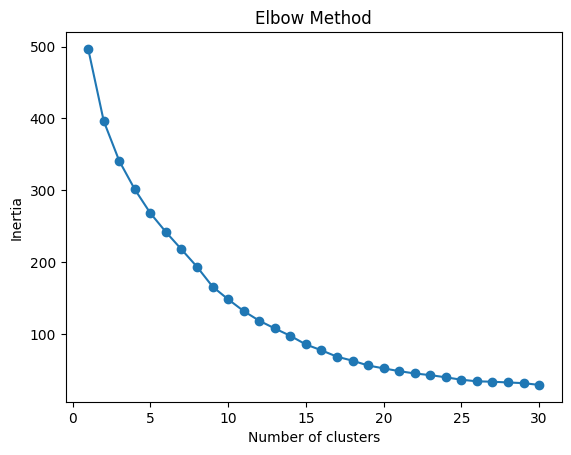

Optimal number of clusters: 11


In [20]:
# Elbow method 및 Kneedle Algorithm를 사용하여 최적의 클러스터 수 찾기
    # Kneedle algorithm 통해 국소적 변화에 민감하다는 elbow method의 한계 보완


# Elbow method를 통해 inertia가 급격히 감소하는 클러스터 수 탐색
inertia = []

# 클러스터 수의 최소값과 최대값 범위 설정
range_min = 1
range_max = round(len(theme_filtered.index)/3)

# 각 클러스터 수에 대해 inertia 값 계산 및 저장
for n_clusters in range(range_min,range_max):
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=10).fit(X)
    inertia.append(kmeans.inertia_)

# Elbow plot 시각화
plt.plot(range(range_min, range_max), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Kneedle Algorithm 사용하여 엘보우 포인트를 찾아 최적의 클러스터 수 결정
kneedle = KneeLocator(range(range_min, range_max), inertia, curve='convex', direction='decreasing')
optimal_clusters = kneedle.elbow
print(f'Optimal number of clusters: {optimal_clusters}')


In [21]:
# 최적의 클러스터 수로 KMeans 클러스터링 수행
kmeans = KMeans(init="k-means++", n_clusters=optimal_clusters, n_init=10, random_state=123).fit(X)

# Node2Vec-Kmeans algorithm을 통해 탐지된 네트워크 커뮤니티 결과를 node 속성 데이터프레임에 저장
dict_n2v = dict(zip(emb_df.index, kmeans.labels_))
nodes['cluster_n2v'] = nodes['node'].map(dict_n2v)

# 커뮤니티 탐지 결과에 대한 modularity 값 계산
n2v_modularity = cm.modularity(dict_n2v, G, weight="width")

# 커뮤니티 탐지 결과에 대한 테마 표준편차 값 계산
grouped_n2v = nodes.groupby('cluster_n2v')['node'].apply(list).reset_index()  # 커뮤니티 별 테마 이름 저장
community_sizes_n2v = grouped_n2v['node'].apply(len).tolist()     # 커뮤니티별 테마 개수 저장
std_dev_n2v = np.std(community_sizes_n2v)     # 테마 표준편차 값 계산 (커뮤니티 별 테마 수의 분산 정보)

# 커뮤니티 탐지 결과에 대한 modularity, 테마 표준편차 결과
print("Modularity: ", n2v_modularity)
print("Theme SD: ", std_dev_n2v)

Modularity:  0.5970258802710692
Theme SD:  4.961004963506274


In [22]:
# Node2Vec-Kmeans algorithm으로 탐지된 커뮤니티 별로 색상을 다르게 지정하여 시각화

# 네트워크 그래프 생성 및 노드, 에지 정보 추가
G3 = nx.Graph()
for idx, row in nodes.iterrows():
    G3.add_node(row['node'], label=row['node'], size=row['count_rescaled'], group=row['cluster_n2v'])
for idx, row in edges.iterrows():
    G3.add_edge(row['node1'], row['node2'], value=row['weight_rescaled'], color="#D3D3D3")

# pyvis 라이브러리 이용하여 html 파일로 시각화 결과 저장
net3 = Network(notebook=True, cdn_resources='remote')
net3.set_options(json.dumps(options))
net3.from_nx(G3)
# net3.show('./result/week3/graph_node2vec.html')

#### 3. Spectral clustering (kmeans)

In [23]:
# 라플라시안 행렬 계산
L = nx.linalg.laplacianmatrix.laplacian_matrix(G)
L_np = L.toarray()      # 이후 계산 위해 numpy 행렬로 변환

# 고유값, 고유벡터 계산
eig_val, eig_vec = eig(L_np)

# 상위 n개 고유벡터 선택 ( n = 앞서 node2vec+kmeans에서 선택된 최적의 클러스터 수 )
top_k_eigenvectors = eig_vec[:, np.argsort(eig_val)[:optimal_clusters]]

# 라플라시안의 고유벡터 이용해 KMeans 클러스터링 수행
    # 최적의 클러스터 수는 node2vec+kmeans에서 선택된 것과 동일하게 지정합니다.
kmeans2 = KMeans(init="k-means++", n_clusters=optimal_clusters, n_init=10, random_state=123).fit(top_k_eigenvectors)

# Spectral clustering algorithm을 통해 탐지된 네트워크 커뮤니티 결과를 node 속성 데이터프레임에 저장
dict_spec = dict(zip(list(G.nodes), kmeans2.labels_))
nodes['cluster_spec'] = nodes['node'].map(dict_spec)

# 커뮤니티 탐지 결과에 대한 modularity 값 계산
spec_modularity = cm.modularity(dict_spec, G, weight="width")

# 커뮤니티 탐지 결과에 대한 테마 표준편차 값 계산
grouped_spec = nodes.groupby('cluster_spec')['node'].apply(list).reset_index()  # 커뮤니티 별 테마 이름 저장
community_sizes_spec = grouped_spec['node'].apply(len).tolist()     # 커뮤니티별 테마 개수 저장
std_dev_spec = np.std(community_sizes_spec)     # 테마 표준편차 값 계산 (커뮤니티 별 테마 수의 분산 정보)

# 커뮤니티 탐지 결과에 대한 modularity, 테마 표준편차 결과
print("Modularity: ", spec_modularity)
print("Theme SD: ", std_dev_spec)

Modularity:  0.5398359106356452
Theme SD:  11.276392366062314


In [24]:
# Spectral clustering algorithm으로 탐지된 커뮤니티 별로 색상을 다르게 지정하여 시각화

# 네트워크 그래프 생성 및 노드, 에지 정보 추가
G4 = nx.Graph()
for idx, row in nodes.iterrows():
    G4.add_node(row['node'], label=row['node'], size=row['count_rescaled'], group=row['cluster_spec'])
for idx, row in edges.iterrows():
    G4.add_edge(row['node1'], row['node2'], value=row['weight_rescaled'], color="#D3D3D3")

# pyvis 라이브러리 이용하여 html 파일로 시각화 결과 저장
net4 = Network(notebook=True, cdn_resources='remote')
net4.set_options(json.dumps(options))
net4.from_nx(G4)
# net4.show('./result/week3/graph_spectral.html')

In [25]:
# 세 방법론의 정량적 평가 결과 비교

print("\n\n ============== Louvain Algorithm ============== \n")

print("Modularity: ", louvain_modularity)
print("Theme SD: ", std_dev_louv)

print("\n\n ============== Node2Vec + Kmeans ============== \n")

print("Modularity: ", n2v_modularity)
print("Theme SD: ", std_dev_n2v)

print("\n\n ============== Spectral + Kmeans ============== \n")

print("Modularity: ", spec_modularity)
print("Theme SD: ", std_dev_spec)




 ============== Louvain Algorithm ============== 

Modularity:  0.6325886303766413
Theme SD:  8.248636250920512


 ============== Node2Vec + Kmeans ============== 

Modularity:  0.5970258802710692
Theme SD:  4.961004963506274


 ============== Spectral + Kmeans ============== 

Modularity:  0.5398359106356452
Theme SD:  11.276392366062314


In [26]:
# 세 방법론의 정성적(질적) 평가 결과 비교
print(grouped_louv, "\n\n")
print(grouped_n2v, "\n\n")
print(grouped_spec, "\n\n")

   cluster_louvain                                               node
0                0  [2차전지, LG화학, LNG, SK이노베이션, 그린수소, 니켈, 리튬, 배터리, ...
1                1  [ADC분야, HLB컨소시엄, MLCC, 딥러닝, 바이오, 바이오제약, 세포유전자치...
2                2  [AI, AI 챗봇, ISDS, 게임, 국민연금, 국제투자분쟁, 롯데그룹, 리츠, ...
3                3                                     [상장, 커머스, 코스피]
4                4                                [HSD엔진, 거래량, 스팩, 텍]
5                5          [건설, 건설 중소형, 두산에너빌리티, 방산, 블록딜, 엘리베이터, 조선]
6                6                                      [구리, 금속, 희토류]
7                7                                     [군사정찰위성, 항공우주]
8                8  [ELW, SPAC, 규제, 금리, 금융, 대부업, 대출, 반도체, 벤처, 부동산,...
9                9                                           [김치, 식품] 


    cluster_n2v                                               node
0             0  [AI, AI 챗봇, SPAC, 게임, 대부업, 벤처, 블록체인, 비트코인, 스마트...
1             1  [2차전지, LG화학, 리튬, 배터리, 에너지솔루션, 이차전지, 자동차, 자동차 대...
2             2           

In [27]:
# 최종적으로, node2vec+kmeans 방법론이 테마 네트워크에서 상위 테마 커뮤니티를 탐지하는 데 최적의 알고리즘이라고 결론내릴 수 있었습니다.

### 최종 결과 저장

In [28]:
# 최종 테마 네트워크에는 누락되었지만, 기사에서 자주 언급된 테마(10회 이상 언급)는 중요할 수 있는 테마로 간주하여, 최종 테마 네트워크에 해당 테마를 포함시켰습니다.
missing_themes = func.find_missing_themes(theme_counts, nodes, theme_index_date, count_filter=10)


# 다만 다른 노드(테마)와의 연관이 없기 때문에, 고립된 노드(isolated node)가 됩니다.
# 이렇게 언급 횟수에 기반해 새로 추가되는 테마의 소속 커뮤니티는 99번 커뮤니티로 저장하였습니다.

# 추가될 테마들에 대한 임시 데이터프레임 생성
new_row = pd.DataFrame({'node': list(missing_themes)})
new_row['count'] = new_row['node'].map(count_dict)
new_row['count_rescaled'] = new_row['count']
new_row['cluster_louvain'] = 99
new_row['cluster_n2v'] = 99
new_row['cluster_spec'] = 99

# nodes 데이터프레임에 new_row 데이터프레임 추가
nodes = pd.concat([nodes, new_row], ignore_index=True)
nodes['count_rescaled'] = func.min_max_scaling(nodes['count'])


In [29]:
# 최종적으로 node2vec+kmeans 알고리즘을 통한 커뮤니티 탐지가 가장 최적의 방법론이라고 결론지었습니다. 따라서 이 방법을 통한 커뮤니티 탐지 결과를 최종적인 커뮤니티 탐지 결과로 저장합니다.

final_nodes = nodes[['node', 'count', 'count_rescaled', 'cluster_n2v']]  # louvain, spectral clustering의 커뮤니티 탐지 결과는 탈락시킵니다.
final_nodes = final_nodes.rename(columns={'cluster_n2v': 'cluster'})

# 최종 node와 edge에 대한 정보를 파일로 저장합니다.
final_nodes.to_csv("./result/week3/nodes_june_week3.csv", index=False)
edges.to_csv("./result/week3/edges_june_week3.csv", index=False)